In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('data_China.csv')

In [2]:
df

,Date,核心CPI_同比,AAA_公司债利率,3M_TBill利率,10Y国债利率,政策利率,IEF,2Y国债利率,WTI,GLD,HS300,CPI_同比,PMI,GDP_现价
0,1987-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1,NaN,NaN
1,1987-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN
2,1987-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN
3,1987-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.7,NaN,NaN
4,1987-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,2025-03-31,0.5,0.6504,1.5583,1.7582,1.5,135.0405,1.5900,537.5,723.86,3887.3056,-0.1,50.5,318758.0
459,2025-04-30,0.5,0.6504,1.3886,1.7858,1.5,136.8558,1.5455,471.1,783.92,3770.5705,-0.1,49.0,318758.0
460,2025-05-31,0.6,0.6504,1.3603,1.6700,1.4,135.9953,1.4416,447.9,772.26,3840.2323,-0.1,49.5,318758.0
461,2025-06-30,0.6,0.6504,1.2594,1.6260,1.4,136.5441,1.3800,496.7,764.86,3936.0791,-0.1,49.7,318758.0


In [3]:
# ——— 0. 假设 df 已经读入并含有 Date 列 ———
df['GDP同比']       = df['GDP_现价'].pct_change(12, fill_method=None) * 100
df['收益率曲线_斜率'] = df['10Y国债利率'] - df['2Y国债利率']
df['信用利差']       = df['AAA_公司债利率'] - df['10Y国债利率']
df['Fis_diff']       = df['政策利率'] - df['政策利率'].rolling(60).mean()


def zscore(series, window):
    return (series - series.rolling(window).mean()) / series.rolling(window).std()

df['CPI_z']         = zscore(df['CPI_同比'], 120)
df['GDP_z']         = zscore(df['GDP同比'], 120)
df['制造业PMI_z']          = zscore(df['PMI'], 120)
df['Fis_diff_z']    = zscore(df['Fis_diff'], 120)
df['WTI_z']         = zscore(df['WTI'], 120)
df['收益率曲线_斜率_z'] = zscore(df['收益率曲线_斜率'], 120)

# 计算宏观经济指标的 z‑score
df['Growth_Score']   = df[['GDP_z', '制造业PMI_z']].mean(axis=1)
df['Inflation_Score']= df[['CPI_z', 'WTI_z']].mean(axis=1)
df['Policy_Score']   = df[['Fis_diff_z', '收益率曲线_斜率_z']].mean(axis=1)

# 回报序列
df['HS300_ret']      = df['HS300'].pct_change()
df['IEF_ret']        = df['IEF'].pct_change()
df['60_40_ret']      = df['HS300_ret'] * 0.6 + df['IEF_ret'] * 0.4

# 未来12个月累计回报 & 标签
df['fwd_12m_return'] = df['60_40_ret'].rolling(12).sum().shift(-12)
df['target']         = (df['fwd_12m_return'] < 0).astype(int) # 若未来12个月回报为负，则标记为1（即下跌），否则为0（即上涨）
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 准备训练/测试集
features = ['Growth_Score', 'Inflation_Score', 'Policy_Score']
df_model = df.dropna(subset=features + ['target']).copy()

split_date = '2019-12-31'
train = df_model.loc[:split_date]
test  = df_model.loc[split_date:]

X_train = train[features].replace([np.inf, -np.inf], np.nan).dropna()
y_train = train['target']
X_test  = test [features].replace([np.inf, -np.inf], np.nan).dropna()
y_test  = test ['target']

In [4]:
# df_model

In [5]:
print("y_train unique classes:", y_train.unique())

y_train unique classes: [1 0]


## 单次训练

In [6]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.experimental import enable_halving_search_cv  # noqa
# from sklearn.model_selection import HalvingRandomSearchCV
# from sklearn.ensemble import RandomForestClassifier
# import scipy.stats as stats
#
# # 1) 定义搜索空间（不含 n_estimators）
# param_dist = {
#     'max_depth':         [None] + list(range(2, 21, 2)),
#     'min_samples_split': stats.randint(2, 11),
#     'min_samples_leaf':  stats.randint(1, 6),
#     'max_features':      ['sqrt', 'log2', None],
#     'criterion':         ['gini', 'entropy'],
#     'bootstrap':         [True, False],
#     'oob_score':         [True, False],
#     'class_weight':      [None, 'balanced', 'balanced_subsample'],
#     'max_samples':       stats.uniform(0.5, 0.5),  # 50% ~ 100%
# }
#
# # 2) 基础模型——这里把 n_estimators 交给资源调度
# rf = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1
# )
#
# # 3) 骇缩随机搜索
# search = HalvingRandomSearchCV(
#     rf,
#     param_dist,
#     resource='n_estimators',   # 用树的数量来做 successive halving
#     max_resources=500,         # 最多 500 棵树
#     min_resources=50,          # 最少 50 棵树
#     factor=2,                  # 每轮保留表现最好的 1/factor
#     scoring='roc_auc',
#     cv=StratifiedKFold(5, shuffle=True, random_state=42),
#     random_state=42,
#     n_jobs=-1,
#     verbose=2
# )
#
# # 4) 运行搜索
# search.fit(X_train, y_train)
#
# print("Best params:", search.best_params_)
# print("Best n_estimators:", search.best_params_['n_estimators'])
# best_model = search.best_estimator_
#
# # 5) 验证
# from sklearn.metrics import roc_auc_score, classification_report
# y_proba = best_model.predict_proba(X_test)[:,1]
# y_pred  = best_model.predict(X_test)
# print("Test AUC:", roc_auc_score(y_test, y_proba))
# print(classification_report(y_test, y_pred, digits=3))

In [7]:
# from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.combine import SMOTEENN
# from sklearn.impute    import SimpleImputer
# from sklearn.ensemble  import RandomForestClassifier
# from sklearn.metrics   import roc_auc_score, classification_report
#
# # ——— 1. 定义一个带有缺失值填补 + 采样 + 分类器 的流水线 ———
# pipe = ImbPipeline([
#     ('imputer',  SimpleImputer(strategy='median')),   # 或者 mean、most_frequent
#     ('sampling', SMOTEENN(sampling_strategy='auto', random_state=42)),
#     ('clf',      RandomForestClassifier(
#         n_estimators=400,
#         max_depth=2,
#         min_samples_split=4,
#         min_samples_leaf=2,
#         max_features='sqrt',
#         class_weight='balanced',
#         criterion='entropy',
#         bootstrap=True,
#         oob_score=True,
#         max_samples=0.8,
#         random_state=42,
#         n_jobs=-1
#     ))
# ])
#
# # ——— 2. 在原有的 X_train, y_train 上直接 fit ———
# pipe.fit(X_train, y_train)
#
# # ——— 3. 预测 & 评估 ———
# y_proba = pipe.predict_proba(X_test)[:,1]
# y_pred  = pipe.predict(X_test)
#
# print("SMOTEENN + RF AUC:", roc_auc_score(y_test, y_proba))
# print(classification_report(y_test, y_pred, digits=3))

## 滚动训练

Rolling‑window AUC: 0.7067537432303281
Rolling‑window classification report:
              precision    recall  f1-score   support

           0      0.783     0.644     0.707        73
           1      0.536     0.698     0.606        43

    accuracy                          0.664       116
   macro avg      0.660     0.671     0.656       116
weighted avg      0.692     0.664     0.669       116



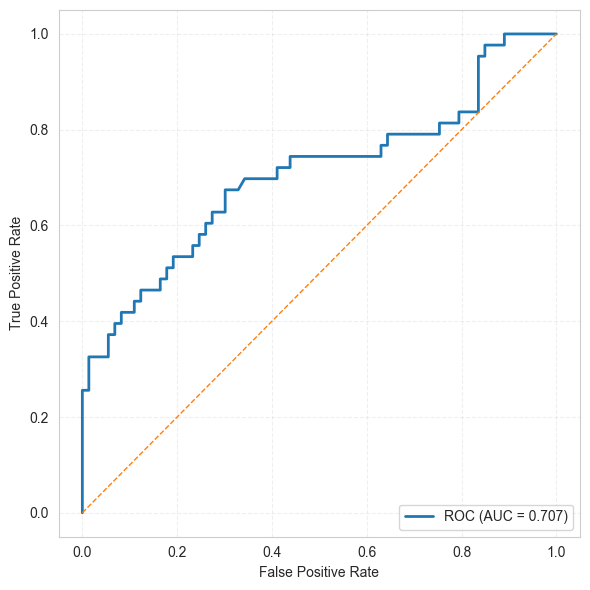

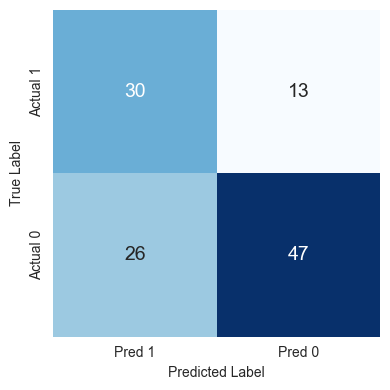

混淆矩阵（DataFrame 形式）：
           Pred 1  Pred 0
Actual 1      30      13
Actual 0      26      47


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ——— 0. 准备 X_full, y_full ———
X_full = df_model[features]
y_full = df_model['target']

# ——— 1. 初始化 ———
imputer = SimpleImputer(strategy='median')
sampler = SMOTEENN(
    smote=SMOTE(k_neighbors=5, random_state=42),
    enn=EditedNearestNeighbours(),
    random_state=42
)
k = sampler.smote.k_neighbors  # 5

# ——— 2. 滚动窗口训练与预测 ———
results = []
initial_train_size = max(60, k+1)
model_last = None  # 用于保存最后一个模型
for t in range(initial_train_size, len(X_full)-1):
    X_tr, y_tr = X_full.iloc[:t], y_full.iloc[:t]
    X_te, y_te = X_full.iloc[t:t+1], y_full.iloc[t]
    X_tr = X_tr.replace([np.inf, -np.inf], np.nan)
    X_te = X_te.replace([np.inf, -np.inf], np.nan)

    X_tr_imp = pd.DataFrame(imputer.fit_transform(X_tr),
                            index=X_tr.index, columns=X_tr.columns)
    X_te_imp = pd.DataFrame(imputer.transform(X_te),
                            index=X_te.index, columns=X_te.columns)

    if y_tr.nunique() > 1 and y_tr.value_counts().min() > k:
        X_res, y_res = sampler.fit_resample(X_tr_imp, y_tr)
    else:
        X_res, y_res = X_tr_imp, y_tr

    model = RandomForestClassifier(
        n_estimators=400,
        max_depth=2,
        min_samples_split=4,
        min_samples_leaf=20,
        max_features='log2',
        class_weight='balanced',
        criterion='entropy',
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model_last = model.fit(X_res, y_res)

    # 安全预测，避免只有1类时报错
    probas = model.predict_proba(X_te_imp)[0]
    class_map = dict(zip(model.classes_, probas))
    proba = class_map.get(1, 0.0)

    results.append((X_te.index[0], y_te, proba))

# ——— 3. 最终评估 ———
_, y_true, y_score = zip(*results)
print("Rolling‑window AUC:", roc_auc_score(y_true, y_score))
print("Rolling‑window classification report:")
print(classification_report(y_true, np.array(y_score) > 0.5, digits=3))
# 3-B) 画 ROC 曲线
fpr, tpr, _ = roc_curve(y_true, y_score)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc_score(y_true, y_score):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1)     # 随机猜测基线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
# === 3-C) 混淆矩阵 ==========================================================
from sklearn.metrics import confusion_matrix
import seaborn as sns                               # 仅用于美化，可替换成 plt.imshow

threshold = 0.5                                     # 你也可以换成 0.3/0.4…
y_pred = (np.array(y_score) >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[1, 0])   # 行：实际  列：预测
cm_df = pd.DataFrame(cm,
                     index=['Actual 1', 'Actual 0'],
                     columns=['Pred 1', 'Pred 0'])

plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("混淆矩阵（DataFrame 形式）：\n", cm_df)

In [14]:
# 准备打包内容
rf_bundle = {
    'model': model_last,                   # 模型
    'features': features,                 # 模型使用的特征
    'macro_df': df[features].copy(),     # 用于回测时输入特征
    'train': train,
    'test': test,
    'target_series': df['target']        # 如果你未来想评估绩效也可以保留
}

# 保存为 pickle 文件
import pickle
with open('rf_model_China.pkl', 'wb') as f:
    pickle.dump(rf_bundle, f)

In [17]:
# 未来12个月最大回撤标签（risk_label）
def calc_max_drawdown(series):
    cummax = series.cummax()
    dd = (series - cummax) / cummax
    return dd.min()

risk_window = 12  # 12个月回撤窗口
return_window = 6  # 6个月收益窗口

risk_labels = []
return_labels = []

nav_series = (1 + df['60_40_ret']).cumprod()  # 假设策略净值 = 累计收益

for i in range(len(nav_series)):
    if i + risk_window < len(nav_series):
        future = nav_series.iloc[i:i + risk_window]
        max_dd = calc_max_drawdown(future)
        risk_labels.append(1 if max_dd < -0.10 else 0)
    else:
        risk_labels.append(np.nan)

    if i + return_window < len(nav_series):
        ret = nav_series.iloc[i + return_window] / nav_series.iloc[i] - 1
        return_labels.append(1 if ret > 0 else 0)
    else:
        return_labels.append(np.nan)

df['risk_label'] = risk_labels
df['return_label'] = return_labels

# 去除NA
df_model_dual = df.dropna(subset=features + ['risk_label', 'return_label']).copy()


— Risk Model —
Rolling-window AUC: 0.7398508699254349
Classification report (thr=0.5):
              precision    recall  f1-score   support

         0.0      0.852     0.648     0.736        71
         1.0      0.510     0.765     0.612        34

    accuracy                          0.686       105
   macro avg      0.681     0.706     0.674       105
weighted avg      0.741     0.686     0.696       105


— Return Model —
Rolling-window AUC: 0.6892883345561261
Classification report (thr=0.5):
              precision    recall  f1-score   support

         0.0      0.625     0.745     0.680        47
         1.0      0.755     0.638     0.692        58

    accuracy                          0.686       105
   macro avg      0.690     0.691     0.686       105
weighted avg      0.697     0.686     0.686       105



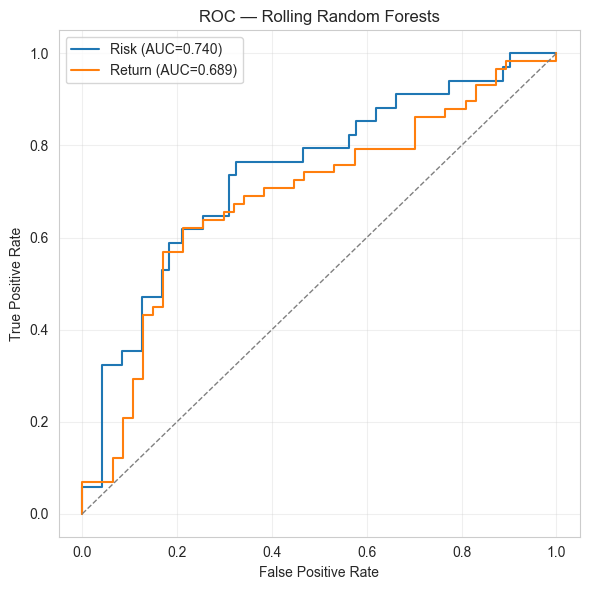


▶ dual_rf_bundle.pkl 已保存（含滚动评估后、全样本重训的两模型）


In [18]:
# ===============================================================
# 0) 数据准备
# ===============================================================
X_all      = df_model_dual[features]            # 特征
y_risk_all = df_model_dual['risk_label']        # 未来 12 个月回撤 >10% ?
y_ret_all  = df_model_dual['return_label']      # 未来 6 个月收益 >0 ?

initial_train_size = 60        # 至少留 60 期做“首个训练窗口”，可按需要调整
rf_kwargs = dict(              # 随机森林统一参数
    n_estimators   = 200,
    max_depth      = 5,
    random_state   = 42,
    n_jobs         = -1,
)
# ===============================================================
# 1) Walk-forward 训练 + 预测
# ===============================================================
risk_res, ret_res = [], []     # (日期, y_true, proba)

for t in range(initial_train_size, len(X_all)):
    # --- 1.1 拆分滚动训练集 / 单点测试集 --------------------------
    X_tr, y_risk_tr = X_all.iloc[:t], y_risk_all.iloc[:t]
    _,    y_ret_tr  = X_tr,          y_ret_all.iloc[:t]
    X_te            = X_all.iloc[t:t+1]
    y_risk_te       = y_risk_all.iloc[t]
    y_ret_te        = y_ret_all.iloc[t]

    # --- 1.2 训练两套模型 ----------------------------------------
    risk_model = RandomForestClassifier(**rf_kwargs)
    ret_model  = RandomForestClassifier(**rf_kwargs)
    risk_model.fit(X_tr, y_risk_tr)
    ret_model .fit(X_tr, y_ret_tr )

    # --- 1.3 滚动预测 -------------------------------------------
    proba_risk = risk_model.predict_proba(X_te)[0][1]   # P(label=1)
    proba_ret  = ret_model .predict_proba(X_te)[0][1]

    risk_res.append((X_te.index[0], y_risk_te, proba_risk))
    ret_res.append((X_te.index[0], y_ret_te , proba_ret ))

# ===============================================================
# 2) 评估滚动窗口表现
# ===============================================================
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

def summarize(results, name):
    _, y_true, y_score = zip(*results)
    print(f"\n— {name} —")
    print("Rolling-window AUC:", roc_auc_score(y_true, y_score))
    print("Classification report (thr=0.5):")
    print(classification_report(y_true, (np.array(y_score) >= 0.5).astype(int), digits=3))
    return y_true, y_score

y_risk_true, y_risk_score = summarize(risk_res, "Risk Model")
y_ret_true , y_ret_score  = summarize(ret_res , "Return Model")

# ===============================================================
# 3) 画两条 ROC 曲线
# ===============================================================
import matplotlib.pyplot as plt
fpr_risk, tpr_risk, _ = roc_curve(y_risk_true, y_risk_score)
fpr_ret , tpr_ret , _ = roc_curve(y_ret_true , y_ret_score )

plt.figure(figsize=(6,6))
plt.plot(fpr_risk, tpr_risk, label=f"Risk (AUC={roc_auc_score(y_risk_true,y_risk_score):.3f})")
plt.plot(fpr_ret , tpr_ret , label=f"Return (AUC={roc_auc_score(y_ret_true ,y_ret_score ):.3f})")
plt.plot([0,1],[0,1],"--",lw=1,color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Rolling Random Forests")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ===============================================================
# 4) 可选：用全部样本重新训练，并与特征一起打包保存
#       （方便回测或线上实时推理）
# ===============================================================
final_risk_model = RandomForestClassifier(**rf_kwargs).fit(X_all, y_risk_all)
final_ret_model  = RandomForestClassifier(**rf_kwargs).fit(X_all, y_ret_all)

dual_rf_bundle = {
    "risk_model" : final_risk_model,
    "return_model": final_ret_model,
    "features"   : features,
    "macro_df"   : df_model[features].copy()
}
with open("dual_rf_bundle.pkl", "wb") as f:
    pickle.dump(dual_rf_bundle, f)

print("\n▶ dual_rf_bundle.pkl 已保存（含滚动评估后、全样本重训的两模型）")

In [ ]:
# import pickle
# dual_rf_bundle = {
#     "risk_model": risk_model_latest,
#     "return_model": ret_model_latest,
#     "features": features,
#     "macro_df": df_model[features].copy()
# }
#
# with open("dual_rf_bundle.pkl", "wb") as f:
#     pickle.dump(dual_rf_bundle, f)
#
# print("dual_rf_bundle.pkl 已保存，包括风险预测模型和收益预测模型")